# Hourly accumulations

This notebook takes the scans within the hour, converts them to rain rate then to rainfall amount, then adds it up until the end of the hour. The hour totals are saved in a hdf file.

Import libraries.

In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os
import numpy as np

import pickle

import pytz
import datetime as dt

from copy import deepcopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

import boto3
from botocore.handlers import disable_signing

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\graph\cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\graph\cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


Read the shapefiles.

In [2]:
reader = shpreader.Reader(r'C:\Users\irene\Documents\Work\Data\GIS\tl_2016_17_cousub\tl_2016_17_cousub.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

Read the gauge locations file and gauge observations file into pandas dataframes, and get the location coordinates.

In [3]:
# load CCN gauge locations
CCN_gauge_locations_fname = 'C:/Users/irene/Documents/Work/Data/Cook_County/CookCounty_gage_locations.csv'
# load CCN gauge observations
CCN_gauge_observations_fname = 'C:/Users/irene/Documents/Work/Data/Cook_County/WaterYear2013.csv'

df_gauge_loc = pd.read_csv(CCN_gauge_locations_fname,header=0)
df_gauge = pd.read_csv(CCN_gauge_observations_fname,header=0)

x = df_gauge_loc['Longitude - West'].values
y = df_gauge_loc['Latitude'].values

Define the function to get the file list from Amazon S3.

In [4]:
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    newkeys = []
    for key in keys:
        if 'MDM' in key:
            pass
        elif key.endswith('.tar'):
            pass
        else:
            newkeys.append(key)
    #print(newkeys)
    return aws_radar, newkeys

In [5]:
def rounder(t):
    """
    Rounds the time to the nearest hour.
    """
    if t.minute >= 30:
        return t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
    else:
        return t.replace(second=0, microsecond=0, minute=0)

In [6]:
# Setting radar, date of radar scans needed, and key index (amount of items in list)
aws_radar, keys = get_radar_scan(station='KLOT', date='2013/04/18', key_index=-400) 

In [7]:
newkeys=keys[0:200:10]

In [8]:
# loop through the keys by iterating nframe
nframe = 14

# open a temporary local file
localfile = tempfile.NamedTemporaryFile(delete=False)
localfile_name = localfile.name
localfile.close()

# download to temporary file and read to radar object using pyart
aws_radar.download_file(newkeys[nframe], localfile_name)
radar = pyart.io.read(localfile_name)

# delete temporary file to save space
os.remove(localfile_name)

In [9]:
gatefilter = pyart.filters.GateFilter(radar)
# Develop your gatefilter first
# exclude masked gates from the gridding
#gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')
# Mask reflectivity
radar.fields["corrected_reflectivity"] = deepcopy(radar.fields["reflectivity"])
radar.fields["corrected_reflectivity"]["data"] = np.ma.masked_where(
    gatefilter._gate_excluded, radar.fields["corrected_reflectivity"]["data"])
rr = pyart.retrieve.est_rain_rate_z(radar, refl_field="corrected_reflectivity")

In [10]:
radar.add_field('rainrate',rr,replace_existing=True)

In [11]:
# Mask out last 10 gates of each ray, this removes the "ring" around the radar.
radar.fields['rainrate']['data'][:, -10:] = np.ma.masked

In [12]:
# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    [radar], gatefilters=[gatefilter],
    grid_shape=(1, 300, 300),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['rainrate'])

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [14]:
grid.fields['rainrate']['data'].shape

(1, 300, 300)

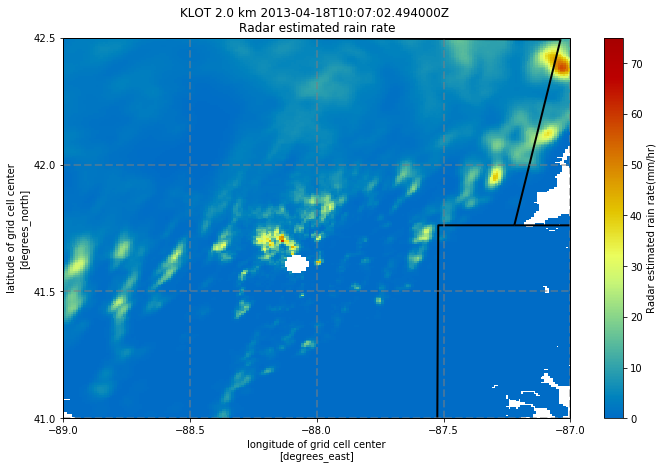

In [15]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[12,7])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('rainrate', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                  vmin=0, vmax=75, lat_lines=np.arange(41, 43, .5),
                  lon_lines=np.arange(-89, -86.5, .5), projection=projection, embelish=True)

In [16]:
# 3.2 Get radar data
# Get slice
radar_slice0 = radar.get_slice(0)
rr_0 = radar.fields['rainrate']['data'][radar_slice0, :]

In [17]:
sitecoords = (radar.longitude['data'][0],radar.latitude['data'][0],radar.altitude['data'][0])
az = radar.azimuth['data'][radar_slice0]
r = radar.range['data']
proj = wrl.georef.epsg_to_osr(4326)

In [18]:
# save the radar parameters
with open('radarparams.pkl','wb') as f:
    pickle.dump([sitecoords, az, r],f)

In [19]:
radar_depth = wrl.trafo.r_to_depth(rr_0,interval=256)

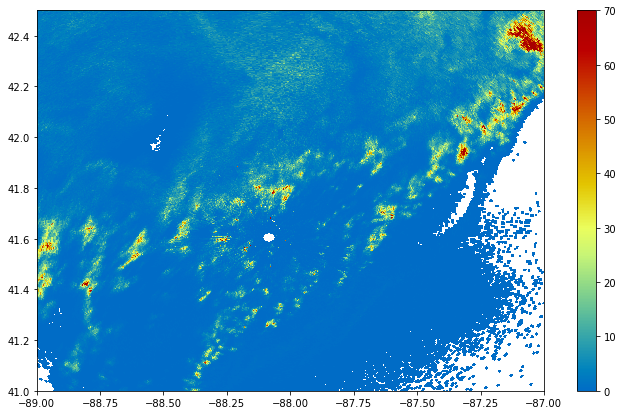

In [20]:
fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax,pm = wrl.vis.plot_ppi(rr_0, r=r, az=az, site=sitecoords,proj=proj, vmin=0, vmax=70, cmap=pyart.graph.cm_colorblind.HomeyerRainbow,ax=ax)
plt.xlim(-89,-87)
plt.ylim(41,42.5)
plt.colorbar(pm)

In [21]:
# create an empty dictionary
fname_dict = {}
for i in arange(1,25,1):
    fname_dict[i] = []
# fill in dictionary
for i in arange(len(keys)):
    fname = keys[i].rsplit('/',1)[-1].strip('.gz')
    dtime_utc = dt.datetime.strptime(fname,'KLOT%Y%m%d_%H%M%S_V06')
    fname_dict[dtime_utc.hour+1].append(keys[i])

In [22]:
fname_dict

{1: ['2013/04/18/KLOT/KLOT20130418_000354_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_000810_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_001228_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_001645_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_002102_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_002518_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_002934_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_003350_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_003807_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_004223_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_004639_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_005057_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_005514_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_005932_V06.gz'],
 2: ['2013/04/18/KLOT/KLOT20130418_010349_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_010806_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_011223_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_011640_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_012057_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_012513_V06.gz',
  '2013/04/18/KLOT/KLOT20130418_0

In [23]:
for hour in list(fname_dict):
    print(hour)
    fnames_within_hour = fname_dict[hour]
    hour_accum = np.zeros((300,300))
    for fname in fnames_within_hour:
        print('.',end='')
        # open a temporary local file
        localfile = tempfile.NamedTemporaryFile(delete=False)
        localfile_name = localfile.name
        localfile.close()

        # download to temporary file and read to radar object using pyart
        aws_radar.download_file(fname, localfile_name)
        radar = pyart.io.read(localfile_name)

        # delete temporary file to save space
        os.remove(localfile_name)
        
        # get local time of radar
        fname = fname.rsplit('/',1)[-1].strip('.gz')
        dtime_utc = dt.datetime.strptime(fname,'KLOT%Y%m%d_%H%M%S_V06')
        dtime_utc = pytz.utc.localize(dtime_utc)

        # 2. Convert reflectivity to rain rate
        gatefilter = pyart.filters.GateFilter(radar)
        # Develop your gatefilter first
        # exclude masked gates from the gridding
        #gatefilter = pyart.filters.GateFilter(radar)
        gatefilter.exclude_transition()
        gatefilter.exclude_masked('reflectivity')
        # Mask reflectivity
        radar.fields["corrected_reflectivity"] = deepcopy(radar.fields["reflectivity"])
        radar.fields["corrected_reflectivity"]["data"] = np.ma.masked_where(
            gatefilter._gate_excluded, radar.fields["corrected_reflectivity"]["data"])
        rr = pyart.retrieve.est_rain_rate_z(radar, refl_field="corrected_reflectivity")

        radar.add_field('rainrate',rr,replace_existing=True)

        # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
        radar.fields['rainrate']['data'][:, -10:] = np.ma.masked
        
        # perform Cartesian mapping, limit to the reflectivity field.
        grid = pyart.map.grid_from_radars(
            [radar], gatefilters=[gatefilter],
            grid_shape=(1, 300, 300),
            grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
            fields=['rainrate'])

        # 3.2 Get radar data
        # Get slice
        #radar_slice0 = radar.get_slice(0)
        rr_0 = grid.fields['rainrate']['data']
        
        # convert rain rate to rain amount
        radar_at_gages_amount = wrl.trafo.r_to_depth(rr_0,interval=256)
        
        hour_accum += radar_at_gages_amount[0]

    savefname = dt.datetime.strftime(dtime_utc.replace(microsecond=0,second=0,minute=0)+dt.timedelta(hours=1), '%Y%m%d_%H%M%S')
    wrl.io.to_hdf5('gridded_KLOT'+savefname+'.hdf5', hour_accum)

    print('')

1
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



2
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



3
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



4
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



5
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



6
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



7
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



8
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



9
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



10
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



11
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



12
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



13
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



14
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



15
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



16
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



17
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



18
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



19
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



20
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



21
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



22
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



23
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



24
.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\irene\Anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [24]:
x_rad, y_rad = grid.get_point_longitude_latitude()

# Saving the objects:
with open('radar_grid.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_rad, y_rad], f)

(300, 300)